<center><h1> Librairies et fonctions</h1></center>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as LA
import copy 
import sklearn.feature_extraction.image as sk_fe
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.linear_model import (LinearRegression,Ridge, RidgeClassifierCV,
                                  LassoCV, Lasso,Ridge)
from sklearn.manifold import Isomap
import matplotlib.colors as colors
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d


#from utils import *

In [2]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()  
def filter_oneVSall(x, y, a):
    datay = np.copy(y)
    datay[y == a] = -1
    datay[y !=a ] = 1
    return x,datay
def filter_oneVsone(x, y, a,b):
    datax, datay = np.copy(x), np.copy(y)
    i = np.where(np.logical_or(datay == a, datay == b))[0]
    new_datay= np.array(datay[i])
    new_datay[new_datay == a] = -1
    new_datay[new_datay == b] = 1
    return np.array(datax[i]),new_datay
def score(datay, datay_predicted):
    return np.mean((np.sign(datay_predicted) == datay[:, np.newaxis]))

In [3]:
datax_train, datay_train = load_usps("../res/USPS/USPS_train.txt")
datax_test, datay_test = load_usps("../res/USPS/USPS_test.txt")

<center><h1> Analyse de la base de données</h1></center>

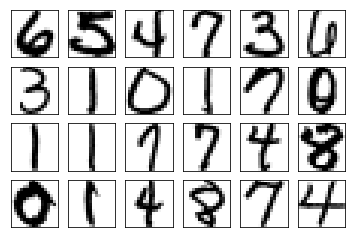

In [4]:
fig, axe = plt.subplots(4, 6, subplot_kw=dict(xticks=[], yticks=[]))
for i in range(len(axe.flat)):
    (axe.flat)[i].imshow(datax_train[i].reshape(16, 16), cmap='gray_r')

Nous souhaitons représenter ces données --> reduction de dimension
https://prateekvjoshi.com/2014/06/21/what-is-manifold-learning/
1/How do we reduce the dimensionality?
2/What exactly is manifold learning?


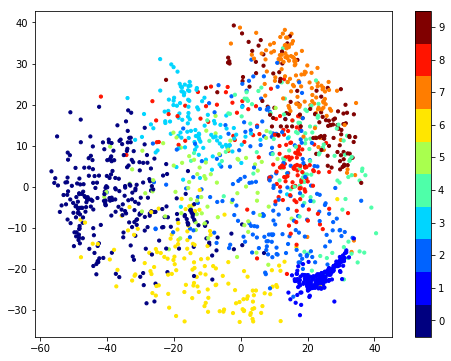

In [5]:
# Projection des données en 2 dimensions
model = Isomap(n_components=2)
projection = model.fit_transform(datax_train[0:1500,:])

# Affichage
plt.figure(figsize=(8,6))
plt.scatter(projection[:, 0], projection[:, 1], s=10, c=datay_train[0:1500], cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

Dans la figure ci-dessus, nous avons projeté les données en deux dimensions. Cette représentation nous permet facilement d'analyser les données et de voir visualement les données qui sembleraient corrélées. 

Nous pouvons remarquer que les distributions du chiffre 6 et 7 sont très éloignées. Alors, nous concluons que les chiffres 6 et 7 ne possèdent pas les mêmes caractéristques. Pour préciser, nous dirons que les écritures manuscrites de ces deux chiffres est très différente. 

Plus loin,  nous considérons les chiffres 3 et 8. Les distributions de ces chiffres sont confondues. Pour interpréter ce résutlat, nous pouvons imaginer que l'écriture manuscrite du chiffre 3 représente la moitité de celle du chiffre 8 de façon verticale. D'où la forte corrélation qui existe entre les chiffres 3 et 8.

<center><h1> Préambule : régression linéaire, régression ridge et LASSO</h1></center>

In [6]:
trainx6_9, trainy6_9 =filter_oneVsone(datax_train, datay_train, 6,9)
testx6_9, testy6_9 = filter_oneVsone(datax_test, datay_test, 6,9)

In [7]:
def sklearn_model(trainx,trainy,testx,testy,model,alpha=0,max_iter=10000):
    myModel=model()
    myModel.fit(trainx,trainy)
    myModel_w=myModel.coef_
    testy_predicted = myModel.predict(testx)
    sc=score(testy,testy_predicted)
    return myModel_w,sc

### Regression linéaire

In [8]:
linear_w,linear_sc=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,LinearRegression)
print("Regression linéaire")
print("Score en test: {:.3f}".format(linear_sc))

Regression linéaire
Score en test: 0.500


### Regression ridge


In [10]:
ridge_w,ridge_sc=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Ridge,alpha=0.01)
print("Regression ridge")
print("Score en test: {:.3f}".format(ridge_sc))

Regression ridge
Score en test: 0.500


### Algorithme du LASSO

In [11]:
lasso_w,lasso_sc=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Lasso,alpha=1e-15)
print("Algorithme du LASSO")
print("Score en test: {:.3f}".format(lasso_sc))

Algorithme du LASSO
Score en test: 0.490


### Effets du paramètre α sur le vecteur de poids W
Nous allons entrainer nos modèles: Ridge regression et Lasso sur les données limitées aux chiffres 6 et 9. Dans cette expérience, nous allons varier les valeurs du paramètre α afin de voir son effet sur le vecteur des poids W.

In [12]:
alphas=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
count0_rid=[]
ridge_ws=[]
for alp in alphas:
    l=Ridge(alpha=alp,max_iter=50000)
    l.fit(trainx6_9,trainy6_9)
    rid_w=l.coef_
    testy_predicted = l.predict(testx6_9)
    sc=score(testy6_9,testy_predicted)
    count0_rid.append(np.count_nonzero(rid_w))
    ridge_ws.append(LA.norm(rid_w))
count0_lasso=[]
lasso_ws=[]
for alp in alphas:
    l=Lasso(alpha=alp,max_iter=50000)
    l.fit(trainx6_9,trainy6_9)
    lasso_w=l.coef_
    testy_predicted = l.predict(testx6_9)
    sc=score(testy6_9,testy_predicted)
    count0_lasso.append(np.count_nonzero(lasso_w))
    lasso_ws.append(LA.norm(lasso_w))

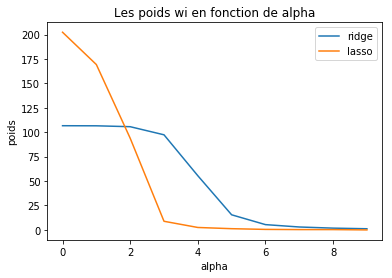

In [13]:
plt.plot(ridge_ws,label='ridge')
plt.plot(lasso_ws,label='lasso')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.title('Les poids wi en fonction de alpha')
plt.axis('tight')
plt.legend()
plt.show()

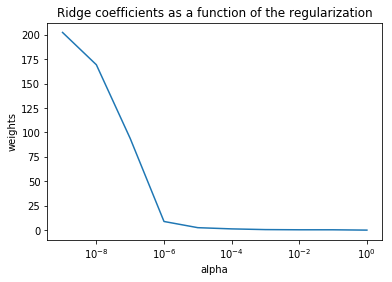

In [14]:
ax = plt.gca()
ax.plot(alphas, lasso_ws)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

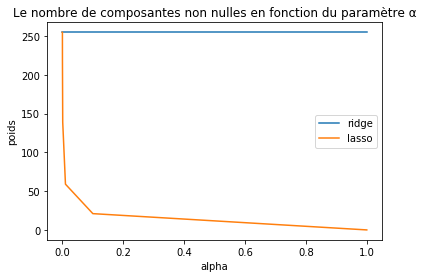

In [15]:
plt.plot(alphas,count0_rid,label='ridge')
plt.plot(alphas,count0_lasso,label='lasso')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend()
plt.title("Le nombre de composantes non nulles en fonction du paramètre α")
plt.show()

À partir de la figure ci-dessus, α pourrait faire partie de trois classes:
- α = 0: dans ce cas, nous retourvons la regréssion linéaire. 
- α --> ∞: dans ce cas, il y a une très grande restriction sur la valeur des poids. Nous remarsuons que les poids s'annulent. Ceci est dû à la pondération infinie sur le carré des poids.
- 0 < α < ∞: ceci représente le cas où les poids ne sont pas nuls. 


In [31]:
rid_w1,ridge_sc=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Ridge,alpha=0.0001)
rid_w2,ridge_sc=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Ridge,alpha=0.9)

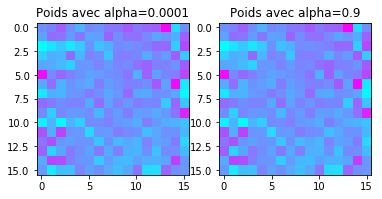

In [32]:
fig=plt.figure()
fig.add_subplot(1, 2, 1)
plt.title("Poids avec alpha=0.0001")
plt.imshow(rid_w1.reshape(16,16),cmap='cool')
fig.add_subplot(1, 2, 2)
plt.title("Poids avec alpha=0.9")
plt.imshow(rid_w2.reshape(16,16),cmap='cool')
plt.show()

<center><h1>LASSO et Inpainting</h1></center>

#### Hypothèse de l'énoncé: nous allons considérer qu’une grande partie de l’image n’a pas de pixels manquants.

In [551]:
def normalize(X):
    Xmin = float(X.min())
    Xmax = float(X.max())
    return (X - Xmin)/(Xmax - Xmin)

def hsv_to_rgb(im):
    return colors.hsv_to_rgb(im[:,:,:])

def read_im(fn):
    im_rgb=plt.imread(fn)
    im_hsv=colors.rgb_to_hsv(im_rgb[:,:,:3])
    im_hsv_norm=normalize(im_hsv)
    return im_rgb,im_hsv,im_hsv_norm

def show_im(im):
    plt.imshow(im)

def get_patch(i,j,h,im):
    N,M,_=im.shape
    a=0
    b=0
    c=0
    d=0
    if h%2==0:
        #pair
        h_p=int(h/2)
        if i-h_p>=0:
            a=i-h_p
        else:
            a=0
        if i+h_p<=N:
            b=i+h_p
        else:
            b=N
        if j-h_p>=0:
            c=j-h_p
        else:
            c=0
        if j+h_p<=M:
            d=j+h_p
        else:
            d=M
    else:
        #impair
        h_i=int(round(h/2))
        if i-h_i>=0:
            a=i-h_i
        else:
            a=0
        if i+h_i+1<=N:
            b=i+h_i+1
        else:
            b=N
        if j-h_i>=0:
            c=j-h_i
        else:
            c=0
        if j+h_i+1<=M:
            d=j+h_i+1
        else:
            d=M
    return im[a:b,c:d]

def getNoiseValue(image):
    v=patchToVector(image)
    union=np.arange(0.0,256.0,0.05)
    return np.random.choice(np.setdiff1d(union,v))
    
def patchToVector(patch):
    p=patch
    return p.flatten()

def vectorToPatch(vect,a,b):
    return np.reshape(vect, (a, b, 3))

def noise(img,prc,value):
    if prc == 0.0: return img
    img_noisy=np.copy(img)
    N=img.shape[0]
    M=img.shape[1]
    nb_pix=N*M
    nb_pix_noisy=int((prc*nb_pix)/100)
    
    for pix in range(nb_pix_noisy):
        x=np.random.choice(np.arange(0,N,1))
        y=np.random.choice(np.arange(0,M,1))
        img_noisy[x][y][0]=value[0]
        img_noisy[x][y][1]=value[1]
        img_noisy[x][y][2]=value[2]
    return img_noisy

def delete_rect(img,i,j,height,width,value):
    img_noisy=np.copy(img)
    N,M,_=img.shape
    a=0
    b=N
    c=0
    d=M
    kk=0
    if width % 2==0:
        w_p=int(width/2)
        if i-w_p>=0:
            a=i-w_p
        else:
            a=0
        if i+w_p<=N:
            b=i+w_p
            kk=1
        else:
            b=N
    else:
        w_i=int(width/2)
        if i-w_i>=0:
            a=i-w_i
        else:
            a=0
        if i+w_i+1<=N:
            b=i+w_i+1
            kk=1
        else:
            b=N
            
    if height % 2==0:
        h_p=int(height/2)
        if j-h_p>=0:
            c=j-h_p
        else:
            c=0
        if j+h_p<=M:
            d=j+h_p
        else:
            d=M
    else:
        h_i=int(height/2)
        if j-h_i>=0:
            c=j-h_i
        else:
            c=0
        if j+h_i+1<=M:
            d=j+h_i+1
        else:
            d=M
    for w in range(a,b):
        for x in range(c,d):
            img_noisy[w][x][0]=value[0]
            img_noisy[w][x][1]=value[1]
            img_noisy[w][x][2]=value[2]
    return img_noisy

def build_dictionary(im,step,h,value):
    N,M,_=im.shape
    axis_n=np.arange(0,N+1,step)
    axis_m=np.arange(0,M+1,step)
    patches_incomp=[]
    patches_comp=[]
    #devide the image into patches
    for i in range(1,len(axis_n)-1):
        for j in range(1,len(axis_m)-1):
            patch=get_patch(axis_n[i],axis_m[j],h,im)
            if np.any(np.any(patch== np.array([value[0],value[1],value[2]]))):
               #patch detected
                patches_incomp.append(patch)
            else:
                patches_comp.append(patch)

    return np.array(patches_incomp),np.array(patches_comp)


def build_data(patches):
    datax=[]
    datay=[]
    for i,patch in enumerate(patches):
            tmpPatches=np.delete(np.array(patches),i,axis=0)
            datax.append(np.array([tmpPatches[:,:,:,0:1].flatten(),tmpPatches[:,:,:,1:2].flatten(),tmpPatches[:,:,:,2:3].flatten()]))
            datay.append(np.array([patch[:,:,0:1].flatten(),patch[:,:,1:2].flatten(),patch[:,:,2:3].flatten()]))
    return np.array(datax), np.array(datay)

#dico: patchs qui ne contiennent aucun pixel manquant
#patch: ne contient aucun pixel manquant
def getW(patch, dico):
    model=Lasso(alpha=0.01,max_iter=10)
    
class Inpainting:
    def __init__(self, im,h=100,step=200, noise=[0,0,0], alpha=0.01,max_iter=10):
        self.im_original=im
        self.h=h
        self.step = step
        self.noise = noise
        self.alpha = alpha
        self.im_reconstructed = self.im_original.copy()
        self.patches_incomp,self.patches_comp=build_dictionary(self.im_original,self.step,self.h,self.noise)
        self.lasso = []
        self.max_iter=max_iter
        for i in range(3):
            self.lasso.append(Lasso(alpha=self.alpha,max_iter=self.max_iter))     


    def fit(self, patch):
        self.patch = patch.copy()
        self.datax, self.datay = {i:[] for i in "hsv"}, {i:[] for i in "hsv"}
        rows, cols, _ = self.patch.shape
        for i in range(self.patch.shape[0]):
            for j in range(self.patch.shape[1]):                    
                if self.noise[0] not in self.patch[i][j]:
                    for k, m in zip("hsv", range(3)):
                        self.datax[k].append(self.patches_comp[:][i][j][m].flatten())
                        self.datay[k].append(self.patch[i][j][m])
                        
        self.lasso[0].fit(self.datax['h'], self.datay['h'])
        self.lasso[1].fit(self.datax['s'], self.datay['s'])
        self.lasso[2].fit(self.datax['v'], self.datay['v'])
    
                        
    def predict(self,patch):
        rows, cols, _ = patch.shape
        for i in range(rows):
            for j in range(cols):
                y_predit = list()
                if self.noise in patch[i, j]:
                    for k in range(3):
                        pixels = [self.patches_comp[:][i][j, k].flatten()]
                        y_predit.append(self.lasso[k].predict(pixels)[0])
                    patch[i, j, :] = np.asarray(y_predit)
        self.patch=patch
        return patch              
    
    def fill(self):     
        p=-9  
        for i in range(len(self.im_reconstructed)):
            for j in range(len(self.im_reconstructed[0])):
                if  self.im_reconstructed[i, j, 0] == self.noise[0] and  self.im_reconstructed[i, j, 1] == self.noise[1] and self.im_reconstructed[i, j, 2] == self.noise[2]:
                    patch = get_patch(i, j, self.h, self.im_reconstructed)
                    self.fit(patch)
                    self.patch=patch
                    a,b,c,d= get_Frame(i, j, self.h, self.im_reconstructed)
                    p=self.predict(patch)
                    self.im_reconstructed[a:b,c:d]=self.predict(patch)
                   
        return self.im_reconstructed,p
    
    def fill_patches(self):
        patch_tmp=-4
        N,M,_=self.im_reconstructed.shape
        axis_n=np.arange(0,N+1,self.step)
        axis_m=np.arange(0,M+1,self.step)
        print(axis_n,axis_m)
        #devide the image into patches
        for i in range(1,len(axis_n)-1):
            for j in range(1,len(axis_m)-1):
                patch=get_patch(axis_n[i],axis_m[j],self.h,self.im_reconstructed)
                if np.any(np.any(patch== np.array([self.noise[0],self.noise[1],self.noise[2]]))):  #patch detected            
                    a=0
                    b=0
                    la=patch.shape[0]-1
                    lb=patch.shape[1]-1
                    while(b<= lb):
                        print(a,b,la,lb)
                        for bb in range(b,lb):
                            if  patch[a,bb, 0] == self.noise[0] and  patch[a,bb, 1] == self.noise[1] and patch[a, bb, 2]:
                                #we detect a missed pixel
                                patch_tmp = get_patch(a, bb, self.h,patch)
                                self.fit(patch_tmp)
                                patch_tmp=self.predict(patch)
                                patch[a][bb][0]=patch_tmp[a][bb][0]
                                patch[a][bb][1]=patch_tmp[a][bb][1]
                                patch[a][bb][2]=patch_tmp[a][bb][2]
                                
                            if  patch[la,bb, 0] == self.noise[0] and  patch[la,bb, 1] == self.noise[1] and patch[la, bb, 2]:
                                #we detect a missed pixel
                                patch_tmp = get_patch(la, bb, self.h,patch)
                                self.fit(patch_tmp)
                                patch_tmp=self.predict(patch)
                                patch[la][bb][0]=patch_tmp[la][bb][0]
                                patch[la][bb][1]=patch_tmp[la][bb][1]
                                patch[la][bb][2]=patch_tmp[la][bb][2]
                                
                    while(a<= la):
                        print(a,b,la,lb)
                        for aa in range(a,la):
                            if  patch[aa,b, 0] == self.noise[0] and  patch[aa,b, 1] == self.noise[1] and patch[aa, b, 2]:
                                #we detect a missed pixel
                                patch_tmp = get_patch(aa, b, self.h,patch)
                                self.fit(patch_tmp)
                                patch_tmp=self.predict(patch)
                                patch[aa][b][0]=patch_tmp[aa][b][0]
                                patch[aa][b][1]=patch_tmp[aa][b][1]
                                patch[aa][b][2]=patch_tmp[aa][b][2]
                                
                            if  patch[aa,lb, 0] == self.noise[0] and  patch[aa,lb, 1] == self.noise[1] and patch[aa, lb, 2]:
                                #we detect a missed pixel
                                patch_tmp = get_patch(aa, lb, self.h,patch)
                                self.fit(patch_tmp)
                                patch_tmp=self.predict(patch)
                                patch[aa][lb][0]=patch_tmp[aa][lb][0]
                                patch[aa][lb][1]=patch_tmp[aa][lb][1]
                                patch[aa][lb][2]=patch_tmp[aa][lb][2]
                        
                        if(a<la):
                            a+=1
                            la-=1
                        if(b<lb):
                            b+=1
                            lb-=1
                        print(a,b,la,lb)
                    #get the 4 coins delimiting the patch on the original image
                    c0,c1,c2,c3= get_Frame(i, j, self.h, self.im_reconstructed)
                    self.im_reconstructed[c0:c1,c2:c3]=patch
        return self.im_reconstructed,patch_tmp
                            

    
    def getWeights(self):
        return((self.lasso[0].coef_+self.lasso[1].coef_+self.lasso[2].coef_)/3).reshape(1,3)

def get_neighbours_patch(img, i, j, h):
    patch_around = []                                                                
    for x in range(max(0, i - h//2), min(i + h//2, len(img))):
        for y in range(max(0, j - h//2), min(j + h//2, len(img[i]))):
            patch_around += patch_to_vec(get_patch(img, x, y, h))
    return patch_around

def get_Frame(i, j, h, im):
    N,M,_=im.shape
    a=0
    b=0
    c=0
    d=0
    if h%2==0:
        #pair
        h_p=int(h/2)
        if i-h_p>=0:
            a=i-h_p
        else:
            a=0
        if i+h_p<=N:
            b=i+h_p
        else:
            b=N
        if j-h_p>=0:
            c=j-h_p
        else:
            c=0
        if j+h_p<=M:
            d=j+h_p
        else:
            d=M
    else:
        #impair
        h_i=int(round(h/2))
        if i-h_i>=0:
            a=i-h_i
        else:
            a=0
        if i+h_i+1<=N:
            b=i+h_i+1
        else:
            b=N
        if j-h_i>=0:
            c=j-h_i
        else:
            c=0
        if j+h_i+1<=M:
            d=j+h_i+1
        else:
            d=M
    return a,b,c,d

def detect_patches(im,h,step):
    N,M,_=im.shape
    axis_n=np.arange(0,N+1,step)
    axis_m=np.arange(0,M+1,step)
    patches_incomp=[]
    #devide the image into patches
    for i in range(1,len(axis_n)-1):
        for j in range(1,len(axis_m)-1):
            patch=get_patch(axis_n[i],axis_m[j],h,im)
            if np.any(np.any(patch== np.array([value[0],value[1],value[2]]))):
               #patch detected
                patches_incomp.append(patch)
            else:
                patches_comp.append(patch)

    return np.array(patches_incomp),np.array(patches_comp)

In [514]:
model=Inpainting(image,h=50,step=10, noise=[0.25,0.25,0.25], alpha=0.1,max_iter=100)
build_data(model.patches_comp,50)


ValueError: could not broadcast input array from shape (3,2500) into shape (3)

In [439]:
reconstructed,patch1= model.fill_patches()

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400] [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400]
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verificat

aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
aa 47
aa 48
1 1 48 48
1 1 48 48
bb 1
bb 2
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
bb 46
bb 47
1 1 48 48
aa 1
aa 2
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
aa 47
2 2 47 47
2 2 47 47
bb 2
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 3

pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pix

bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
11 11 38 38
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
12 12 37 37
12 12 37 37
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
12 12 37 37
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
13 13 36 36
13 13 36 36
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
13 13 36 36
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
14 14 35 35
14 14 35 35
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 3

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.3

12 12 37 37
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
12 12 37 37
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
13 13 36 36
13 13 36 36
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
13 13 36 36
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
14 14 35 35
14 14 35 35
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
14 14 35 35
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
15 15 34 34
15 15 34 34
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 2

y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
patch_tmp (50, 50, 3)
bb 41
bb 42
bb 43
bb 44
bb 45
bb 46
bb 47
bb 48
0 0 49 49
aa 0
aa 1
aa 2
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
aa 47
aa 48
1 1 48 48
1 1 48 48
bb 1
bb 2
bb 3
bb 4
bb 5
bb 6
bb 7
b

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6

aa 28
aa 29
aa 30
aa 31
aa 32
17 17 32 32
17 17 32 32
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
17 17 32 32
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
18 18 31 31
18 18 31 31
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
18 18 31 31
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
19 19 30 30
19 19 30 30
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
19 19 30 30
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
20 20 29 29
20 20 29 29
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
20 20 29 29
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
21 21 28 28
21 21 28 28
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
21 21 28 28
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
22 22 27 27
22 22 27 27
bb 22
bb 23
bb 24
bb 25
bb 26
22 22 27 27
aa 22
aa 23
aa 24
aa 25
aa 26
23 23 26 26
23 23 26 26
bb 23
bb 2

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.3

bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
bb 46
2 2 47 47
aa 2
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
3 3 46 46
3 3 46 46
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
3 3 46 46
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
4 4 45 45


y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.27

aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
5 5 44 44
5 5 44 44
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
5 5 44 44
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
6 6 43 43
6 6 43 43
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
6 6 43 43
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13


bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
bb 46
bb 47
1 1 48 48
aa 1
aa 2
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
aa 47
2 2 47 47
2 2 47 47
bb 2
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
bb 46
2 2 47 47
aa 2
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
a

pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pix

pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pix

y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel

bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
5 5 44 44
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
6 6 43 43
6 6 43 43
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
6 6 43 43
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
7 7 42 42
7 7 42 42
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb

bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
bb 46
2 2 47 47
aa 2
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
3 3 46 46
3 3 46 46
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
3 3 46 46
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
4 4 45 45
4 4 45 45
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb

pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pix

bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
6 6 43 43
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
7 7 42 42
7 7 42 42
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
7 7 42 42
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
8 8 41 41
8 8 41 41
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 3

5 5 44 44
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
6 6 43 43
6 6 43 43
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
6 6 43 43
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
7 7 42 42
7 7 42 42
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
7 7 42 42
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
a

aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
3 3 46 46
3 3 46 46
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
3 3 46 46
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
4 4 45 45
4 4 45 45
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
4 4 45 45
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21


y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_p

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6

aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
9 9 40 40
9 9 40 40
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
9 9 40 40
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
10 10 39 39
10 10 39 39
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
10 10 39 39
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
11 11 38 38
11 11 38 38
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17


pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.3

bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
5 5 44 44
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
6 6 43 43
6 6 43 43
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
6 6 43 43
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
7 7 42 42
7 7 42 42
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb

aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
6 6 43 43
6 6 43 43
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
6 6 43 43
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
7 7 42 42
7 7 42 42
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
7 7 42 42
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
8 8 41

bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
10 10 39 39
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
11 11 38 38
11 11 38 38
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
11 11 38 38
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
12 12 37 37
12 12 37 37
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
12 12 37 37
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 3

pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6

bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
12 12 37 37
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
13 13 36 36
13 13 36 36
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
13 13 36 36
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
14 14 35 35
14 14 35 35
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
14 14 35 35
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
15 15 34 34
15 15 34 34
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
15 15 34 34
aa 15
aa 16
aa 17
aa 18
aa 1

y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.27

y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
patch_tmp (50, 50, 3)
aa 41
aa 42
aa 43
aa 44
aa 45
aa 46
aa 47
aa 48
1 1 48 48
1 1 48 48
bb 1
bb 2
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
bb 46
bb 47
1 1 48 48
aa 1
aa 2
aa 3
aa 4
aa 5
aa 6
aa 7
aa 8
aa 9
aa 10
aa 11
aa 12
aa 13
aa 14
aa 15
aa 16
aa 17
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
aa 31
aa 32
aa 33
aa 34
aa 35
aa 36
aa 37
aa 38
aa 39
aa 40
aa 41
aa 42
aa 43
aa 44
aa 45
aa 4

pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885, 0.2772486274509804]
pixel [array([0.25])]
y_predit [0.6350243137254903]
pixel [array([0.25])]
y_predit [0.6350243137254903, 0.39657411764705885]
pix

18 18 31 31
aa 18
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
aa 30
19 19 30 30
19 19 30 30
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
19 19 30 30
aa 19
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
aa 29
20 20 29 29
20 20 29 29
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
20 20 29 29
aa 20
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
aa 28
21 21 28 28
21 21 28 28
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
21 21 28 28
aa 21
aa 22
aa 23
aa 24
aa 25
aa 26
aa 27
22 22 27 27
22 22 27 27
bb 22
bb 23
bb 24
bb 25
bb 26
22 22 27 27
aa 22
aa 23
aa 24
aa 25
aa 26
23 23 26 26
23 23 26 26
bb 23
bb 24
bb 25
23 23 26 26
aa 23
aa 24
aa 25
24 24 25 25
24 24 25 25
bb 24
24 24 25 25
aa 24
25 25 24 24
corners 125 175 125 175 150 150
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch ver

shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)


shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)
shape of patch verification (50, 50, 3)


In [396]:
model=Inpainting(image,h=50,step=10, noise=[0.25,0.25,0.25], alpha=0.1,max_iter=100)
model.fit()
reconstructed,patch1= model.fill_patches()


[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400] [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400]
shape (50, 50, 3)
0 0 49 49
bb 0
bb 1
bb 2
bb 3
bb 4
bb 5
bb 6
bb 7
bb 8
bb 9
bb 10
bb 11
bb 12
bb 13
bb 14
bb 15
bb 16
bb 17
bb 18
bb 19
bb 20
bb 21
bb 22
bb 23
bb 24
bb 25
bb 26
bb 27
bb 28
bb 29
bb 30
bb 31
bb 32
bb 33
bb 34
bb 35
bb 36
bb 37
bb 38
bb 39
bb 40
bb 41
bb 42
bb 43
bb 44
bb 45
fec2
yap shapppe (50, 50, 3)
pixel [array([0.25])]


NotFittedError: This Lasso instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


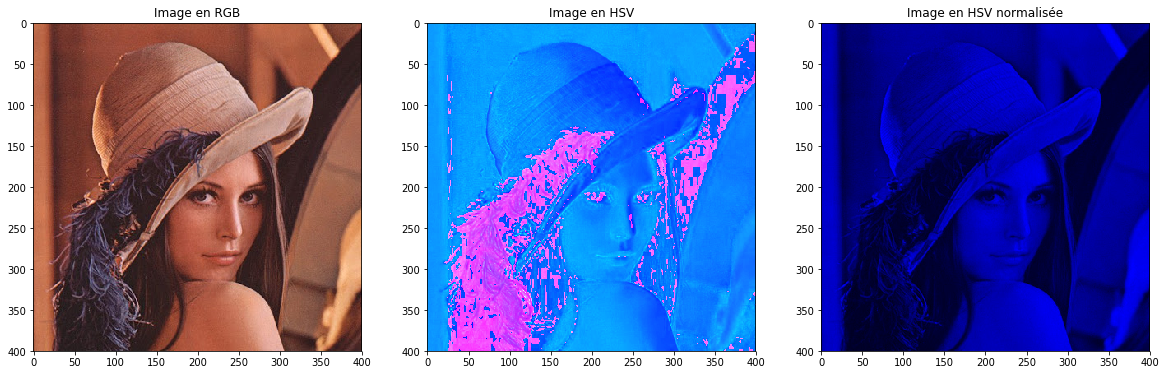

In [395]:
im_rgb,im_hsv,im_hsv_norm=read_im("../res/lena.jpg")
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image en RGB")
plt.imshow(im_rgb)
fig.add_subplot(1, 3, 2)
plt.title("Image en HSV")
plt.imshow(im_hsv)
fig.add_subplot(1, 3, 3)
plt.title("Image en HSV normalisée")
plt.imshow(im_hsv_norm)


In [ ]:
%reset -f


#### Test sur un dictionnaire issu de l’image complète sans bruit

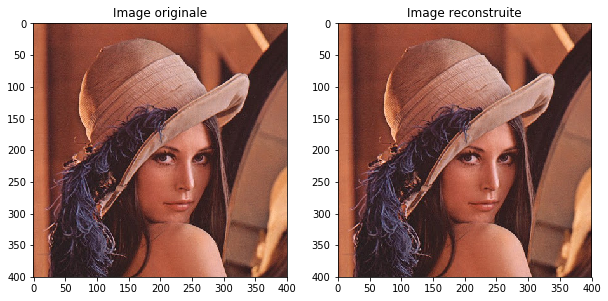

In [523]:
model=Inpainting(normalize(im_rgb),h=10,step=200, noise=[0.5,0.5,0.5], alpha=0.01,max_iter=100)
new_img = model.fill()
fig=plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(im_rgb)
fig.add_subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(new_img)
plt.show()

Comme L'image originale ne contient aucun pixel manquant, nous n'avaons rien à compléter. Alors, le fit n'est jamais executée. Par conséquent, le Lasso ne crée pas d'attribut 'poids'.

#### Test sur un dictionnaire issu de l’image complète bruitée

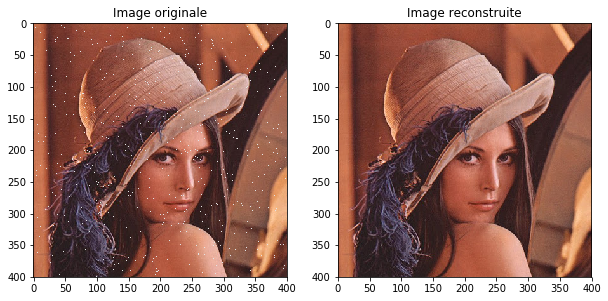

In [530]:
image_noisy=noise(normalize(im_rgb),0.8,[0.9,0.9,0.9])
model=Inpainting(image_noisy,h=5,step=10, noise=[0.9,0.9,0.9], alpha=0.001,max_iter=1000)
new_img= model.fill()
fig=plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image_noisy)
fig.add_subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(new_img)
plt.show()

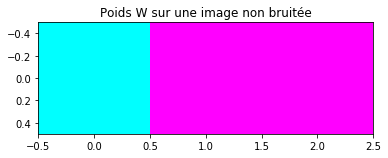

In [531]:
plt.title("Poids W sur une image non bruitée")
plt.imshow(model.getWeights(),cmap='cool')

#### Test en particulier sur un patch  sans bruit

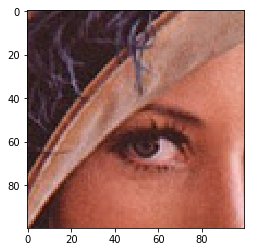

In [532]:
patch=get_patch(200,200,100,normalize(im_rgb))
plt.imshow(patch)

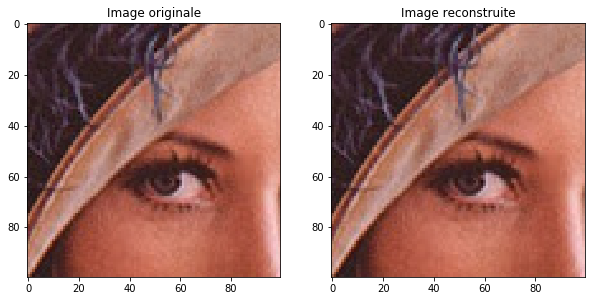

In [533]:
model=Inpainting(patch,h=5,step=10, noise=[0.5,0.5,0.5], alpha=0.1,max_iter=100)
new_img= model.fill()
fig=plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(patch)
fig.add_subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(new_img)
plt.show()

#### Test en particulier sur un patch  avec du bruit

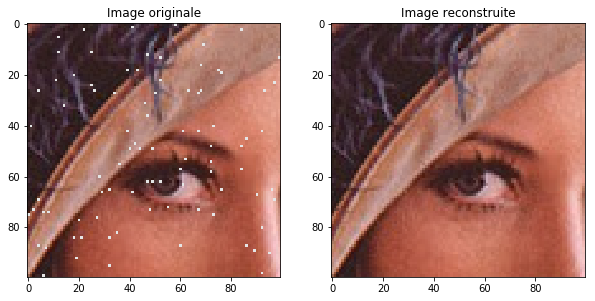

In [535]:
image_noisy=noise(patch,0.9,[0.9,0.9,0.9])
model=Inpainting(image_noisy,h=5,step=10, noise=[0.9,0.9,0.9], alpha=0.1,max_iter=100)
new_img= model.fill()
fig=plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.title("Image originale")

plt.imshow(image_noisy)
fig.add_subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(new_img)
plt.show()

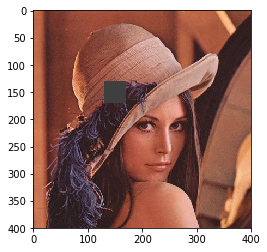

In [555]:
image=delete_rect(normalize(im_rgb),150,150,40,40,[0.25,0.25,0.25])
plt.imshow(image)

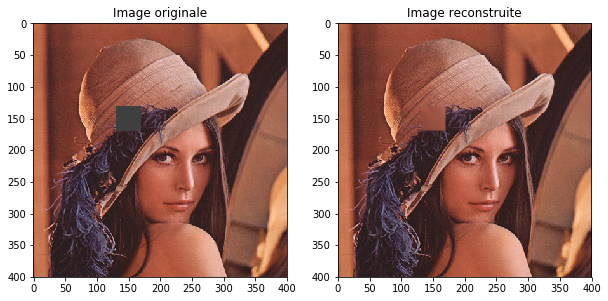

In [559]:
model=Inpainting(image,h=5,step=10, noise=[0.25,0.25,0.25], alpha=0.1,max_iter=100)
new_img,p= model.fill()
fig=plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image)
fig.add_subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(new_img)

#### Proposition d'une heuristique intelligente

À ce stade, nous remarqons une reconstruction de l'image pas très satisfaisante. Cette reconstruction nous montre que l'ordre dans lequel on remplit notre image un un très grand impact sur le résultat. 

Une heurstique qui permetterait de remplir de manière intelligente serait de :
1/ Détecter la présence d'un patch manquant.
2/ À chaque itération remplir les bordures du patch en fonction des pixels environnants.
S'arrêter lorsuqe l'on arrive à remplir le centre de l'image.

In [ ]:
v=patchToVector(im_hsv)
p=vectorToPatch(v,800,600)
p=normalize(p)
plt.imshow(p)

In [263]:
image

array([[[0.76078431, 0.42352941, 0.28627451],
        [0.77647059, 0.43921569, 0.30196078],
        [0.75686275, 0.42745098, 0.28627451],
        ...,
        [0.58823529, 0.32156863, 0.23921569],
        [0.56078431, 0.30980392, 0.21176471],
        [0.55294118, 0.31764706, 0.21568627]],

       [[0.76862745, 0.43137255, 0.29411765],
        [0.77647059, 0.44705882, 0.30588235],
        [0.76078431, 0.43137255, 0.29019608],
        ...,
        [0.58823529, 0.30980392, 0.22352941],
        [0.56862745, 0.30980392, 0.21568627],
        [0.57647059, 0.33333333, 0.23529412]],

       [[0.77254902, 0.44313725, 0.30196078],
        [0.78039216, 0.45098039, 0.30980392],
        [0.76862745, 0.43921569, 0.29803922],
        ...,
        [0.6       , 0.31764706, 0.23137255],
        [0.57254902, 0.31372549, 0.21960784],
        [0.57647059, 0.3254902 , 0.22745098]],

       ...,

       [[0.63137255, 0.3372549 , 0.22352941],
        [0.6627451 , 0.36862745, 0.25490196],
        [0.69803922, 0

#### Image denoising using dictionary learning

In [ ]:
[0.76078431, 0.42352941, 0.28627451],
        [0.77647059, 0.43921569, 0.30196078],

In [391]:
model=Inpainting(image,h=50,step=10, noise=[0.25,0.25,0.25], alpha=0.1,max_iter=100)
model.fit()

In [235]:
get_Frame(2,2,2,patch1)

(1, 3, 1, 3)

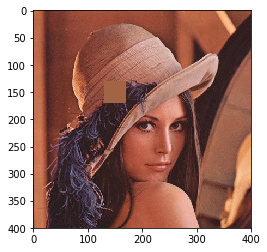

In [441]:
plt.imshow(reconstructed)
plt.show()

In [232]:
c0,c1,c2,c3= getframe(300,300, 5, image)
image[c0:c1,c2:c3]=patch1
plt.imshow(image)
plt.show()

NameError: name 'getframe' is not defined